In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from pandas.plotting import scatter_matrix
from keras.losses import mse
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from numpy.linalg import norm
import random
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [234]:
df_atmes = pd.read_csv("americanToadPadraoMes.csv")
#df_gfmes = pd.read_csv("greenFrogPadraoMes.csv")
#df_spmes = pd.read_csv("springPeeperPadraoMes.csv")
#df_atest = pd.read_csv("americanToadPadraoEstacao.csv")
#df_gfest = pd.read_csv("greenFrogPadraoEstacao.csv")
#df_spest = pd.read_csv("springPeeperPadraoEstacao.csv")

In [235]:
df_atmes.drop('Unnamed: 0',axis=1,inplace=True)

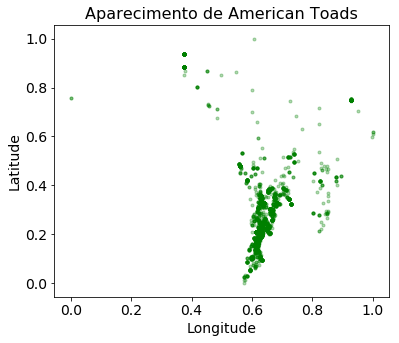

In [132]:
plt.figure(figsize=(6,5))
plt.rc('font',size=14)
plt.rc('axes',titlesize=16)
plt.scatter(df_atmes["lng"], df_atmes["lat"],marker=".",alpha='0.3',color="green")
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title("Aparecimento de American Toads")
plt.show()

# Feature Selection

In [236]:
def classifica_dict(d, reverso):
    feature = []
    valor = []
    for b in sorted(d, key = d.get,reverse=reverso):
        feature.append(b)
        valor.append(d[b])
    return feature, valor

In [248]:
def interquartile_ranking(data):
    ir = {}
    zeros = []
    for c in data.columns:
        inter = data[c].quantile(q=0.75) - data[c].quantile(q=0.25)
        if (inter == 0):
            zeros.append(c)
        else:
            ir[c] = inter 
    return classifica_dict(ir,reverso=False), zeros

In [249]:
ir, zeros = interquartile_ranking(df_atmes)
ir

(['lng',
  'maxwspdm',
  'meanwindspdm',
  'date',
  'maxtempm',
  'meantempm',
  'minwspdm',
  'mintempm',
  'lat',
  'maxdewptm',
  'heatingdegreedays',
  'maxpressurem',
  'mindewptm',
  'meanpressurem',
  'maxhumidity',
  'minpressurem',
  'meandewptm',
  'humidity',
  'minhumidity',
  'gdegreedays',
  'meanwdird'],
 [0.031597279692543,
  0.05500000000000001,
  0.05714285714285715,
  0.09090909090909088,
  0.11764705882352944,
  0.12962962962962965,
  0.1313131313131313,
  0.13793103448275867,
  0.15135276256531535,
  0.1568627450980392,
  0.15789473684210528,
  0.16326530612244888,
  0.16666666666666674,
  0.17071147064924203,
  0.1842105263157895,
  0.19148936170212771,
  0.1923076923076923,
  0.25,
  0.27083333333333326,
  0.4,
  0.6481994459833795])

In [251]:
# Elimina as features com intervalo entre quartis zerado
for c in zeros:
    df_atmes.drop(c,axis=1,inplace=True)

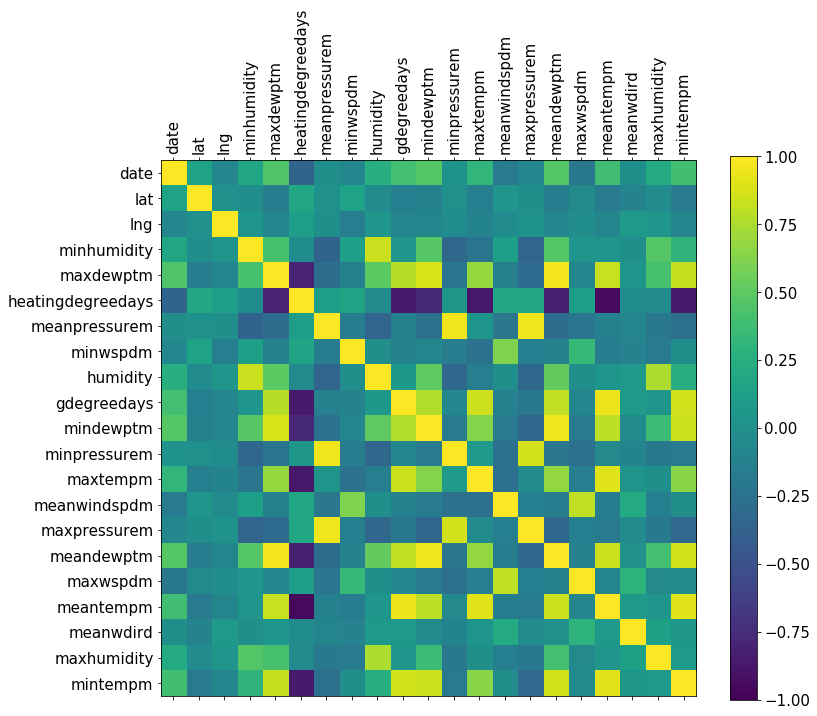

In [252]:
# Plota matriz de correlação
# Quanto mais correlacionadas duas features, mais forte é a cor de interseção entre elas
# crescem justas na mesma direção = bem correlacionadas
# crescem em direções opostas = mal correlacionadas
plt.rc('font', size=15)
plt.rc('axes', titlesize=22)
correlations = df_atmes.corr()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,input_dim,1)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(df_atmes.columns,rotation=90)
ax.set_yticklabels(df_atmes.columns)
plt.plot()
plt.show()

# Arquiteturas de Redes Autoencoders

In [257]:
# Separa as base de treino e teste
X_trainAtMes, X_testAtMes = train_test_split(df_atmes, test_size=0.30, random_state=42)

In [258]:
batch = len(df_atmes)//10
batch

367

In [259]:
attest_dim = len(X_testAtMes)//10
attest_dim

110

In [260]:
input_dim = len(df_atmes.columns)
input_dim

21

## Arquitetura 1: Sem redução, apenas Dropout

In [261]:
# Outra tentativa
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
x = Dropout(0.3)(entrada)
x = Dense(input_dim,activation="tanh")(x)
decoded = Dense(input_dim,activation="sigmoid")(x)

In [262]:
# Cria o modelo para a rede anteriormente montada
ae1 = Model(entrada,decoded)

In [263]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
ae1.compile(optimizer='adam', loss='mse')

In [264]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history_ae1 = ae1.fit(X_trainAtMes, X_trainAtMes,
                epochs=10000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 1800 samples, validate on 772 samples
Epoch 1/10000
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0819 - val_loss: 0.0734
Epoch 2/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0745 - val_loss: 0.0655
Epoch 3/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0679 - val_loss: 0.0585
Epoch 4/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0620 - val_loss: 0.0524
Epoch 5/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0570 - val_loss: 0.0471
Epoch 6/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0516 - val_loss: 0.0426
Epoch 7/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0477 - val_loss: 0.0388
Epoch 8/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0437 - val_loss: 0.0355
Epoch 9/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0407 - val_loss: 0.0328


1800/1800 [==============================] - 0s 19us/step - loss: 0.0166 - val_loss: 0.0136
Epoch 78/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0162 - val_loss: 0.0134
Epoch 79/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0166 - val_loss: 0.0133
Epoch 80/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0164 - val_loss: 0.0132
Epoch 81/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0164 - val_loss: 0.0131
Epoch 82/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0161 - val_loss: 0.0130
Epoch 83/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0161 - val_loss: 0.0129
Epoch 84/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0161 - val_loss: 0.0129
Epoch 85/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0159 - val_loss: 0.0128
Epoch 86/10000
1800/1800 [==========================

1800/1800 [==============================] - 0s 15us/step - loss: 0.0132 - val_loss: 0.0088
Epoch 154/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0132 - val_loss: 0.0088
Epoch 155/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0130 - val_loss: 0.0087
Epoch 156/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0133 - val_loss: 0.0087
Epoch 157/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0130 - val_loss: 0.0087
Epoch 158/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0128 - val_loss: 0.0087
Epoch 159/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0129 - val_loss: 0.0086
Epoch 160/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0131 - val_loss: 0.0086
Epoch 161/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0133 - val_loss: 0.0086
Epoch 162/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 16us/step - loss: 0.0126 - val_loss: 0.0076
Epoch 230/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0123 - val_loss: 0.0076
Epoch 231/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0124 - val_loss: 0.0076
Epoch 232/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0121 - val_loss: 0.0076
Epoch 233/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0125 - val_loss: 0.0075
Epoch 234/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0122 - val_loss: 0.0075
Epoch 235/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0123 - val_loss: 0.0075
Epoch 236/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0127 - val_loss: 0.0075
Epoch 237/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0124 - val_loss: 0.0075
Epoch 238/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 18us/step - loss: 0.0119 - val_loss: 0.0072
Epoch 306/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0118 - val_loss: 0.0071
Epoch 307/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0120 - val_loss: 0.0071
Epoch 308/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0118 - val_loss: 0.0071
Epoch 309/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0120 - val_loss: 0.0071
Epoch 310/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0120 - val_loss: 0.0071
Epoch 311/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0118 - val_loss: 0.0071
Epoch 312/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0117 - val_loss: 0.0071
Epoch 313/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0117 - val_loss: 0.0071
Epoch 314/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 18us/step - loss: 0.0116 - val_loss: 0.0068
Epoch 382/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0117 - val_loss: 0.0068
Epoch 383/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0116 - val_loss: 0.0068
Epoch 384/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0118 - val_loss: 0.0068
Epoch 385/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0117 - val_loss: 0.0068
Epoch 386/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0113 - val_loss: 0.0068
Epoch 387/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0117 - val_loss: 0.0068
Epoch 388/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0116 - val_loss: 0.0068
Epoch 389/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0116 - val_loss: 0.0068
Epoch 390/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 17us/step - loss: 0.0112 - val_loss: 0.0067
Epoch 458/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0113 - val_loss: 0.0066
Epoch 459/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0112 - val_loss: 0.0066
Epoch 460/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0116 - val_loss: 0.0066
Epoch 461/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0116 - val_loss: 0.0066
Epoch 462/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0116 - val_loss: 0.0066
Epoch 463/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0113 - val_loss: 0.0066
Epoch 464/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0119 - val_loss: 0.0066
Epoch 465/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0112 - val_loss: 0.0066
Epoch 466/10000
1800/1800 [=================

Epoch 533/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0118 - val_loss: 0.0065
Epoch 534/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0114 - val_loss: 0.0066
Epoch 535/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0111 - val_loss: 0.0066
Epoch 536/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0115 - val_loss: 0.0066
Epoch 537/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0111 - val_loss: 0.0066
Epoch 538/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0111 - val_loss: 0.0066
Epoch 539/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0112 - val_loss: 0.0066
Epoch 540/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0114 - val_loss: 0.0065
Epoch 541/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0115 - val_loss: 0.0065
Epoch 542/10000
1800/1800 [=

1800/1800 [==============================] - 0s 16us/step - loss: 0.0109 - val_loss: 0.0066
Epoch 609/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0112 - val_loss: 0.0066
Epoch 610/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0113 - val_loss: 0.0065
Epoch 611/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0110 - val_loss: 0.0065
Epoch 612/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0107 - val_loss: 0.0065
Epoch 613/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0109 - val_loss: 0.0066
Epoch 614/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0115 - val_loss: 0.0066
Epoch 615/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0110 - val_loss: 0.0065
Epoch 616/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0110 - val_loss: 0.0065
Epoch 617/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 14us/step - loss: 0.0106 - val_loss: 0.0067
Epoch 685/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0103 - val_loss: 0.0068
Epoch 686/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0105 - val_loss: 0.0067
Epoch 687/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0106 - val_loss: 0.0066
Epoch 688/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0105 - val_loss: 0.0066
Epoch 689/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0108 - val_loss: 0.0067
Epoch 690/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0106 - val_loss: 0.0066
Epoch 691/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0110 - val_loss: 0.0066
Epoch 692/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0105 - val_loss: 0.0067
Epoch 693/10000
1800/1800 [=================

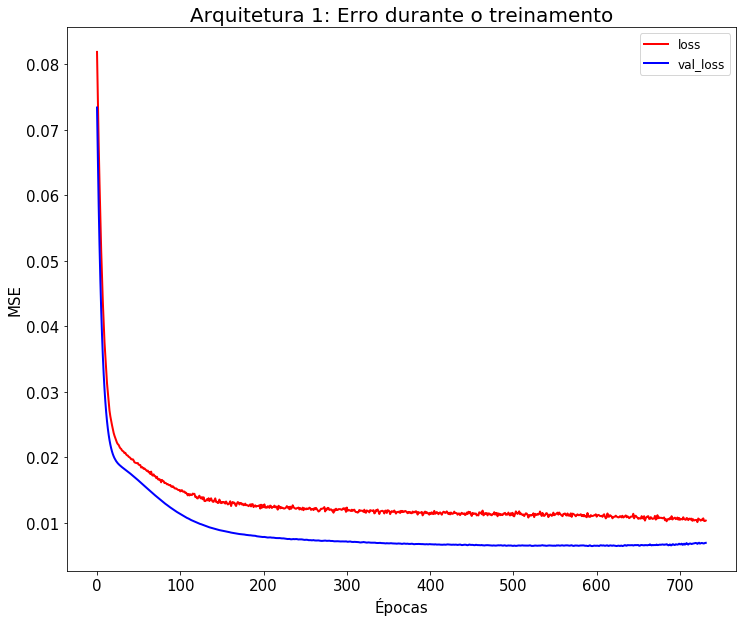

In [265]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history_ae1.history['loss'],color='r',label="loss",linewidth=2)
plt.plot(history_ae1.history['val_loss'],color='b',label="val_loss",linewidth=2)
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Arquitetura 1: Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [266]:
np.min(history_ae1.history['loss'])

0.01013179611414671

In [267]:
np.min(history_ae1.history['val_loss'])

0.006475047785016693

## Arquitetura 2: Redução e com Dropout

In [268]:
# Arquitetura que o professor falou
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
x = Dropout(0.3)(entrada)
x = Dense(encoding_dim1,activation="relu")(x)
decoded = Dense(input_dim,activation="sigmoid")(x)

In [269]:
# Cria o modelo para a rede anteriormente montada
ae2 = Model(entrada,decoded)

In [270]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
ae2.compile(optimizer='adam', loss='mse')

In [271]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history_ae2 = ae2.fit(X_trainAtMes, X_trainAtMes,
                epochs=10000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 1800 samples, validate on 772 samples
Epoch 1/10000
1800/1800 [==============================] - 2s 871us/step - loss: 0.0859 - val_loss: 0.0806
Epoch 2/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0829 - val_loss: 0.0783
Epoch 3/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0802 - val_loss: 0.0763
Epoch 4/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0775 - val_loss: 0.0744
Epoch 5/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0751 - val_loss: 0.0727
Epoch 6/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0729 - val_loss: 0.0710
Epoch 7/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0706 - val_loss: 0.0694
Epoch 8/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0683 - val_loss: 0.0676
Epoch 9/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0659 - val_loss: 0.065

1800/1800 [==============================] - 0s 15us/step - loss: 0.0183 - val_loss: 0.0156
Epoch 78/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0184 - val_loss: 0.0155
Epoch 79/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0154
Epoch 80/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0183 - val_loss: 0.0153
Epoch 81/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0182 - val_loss: 0.0153
Epoch 82/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0182 - val_loss: 0.0152
Epoch 83/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0181 - val_loss: 0.0151
Epoch 84/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0181 - val_loss: 0.0151
Epoch 85/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0178 - val_loss: 0.0150
Epoch 86/10000
1800/1800 [==========================

1800/1800 [==============================] - 0s 17us/step - loss: 0.0150 - val_loss: 0.0112
Epoch 154/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0147 - val_loss: 0.0112
Epoch 155/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0149 - val_loss: 0.0111
Epoch 156/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0146 - val_loss: 0.0111
Epoch 157/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0146 - val_loss: 0.0110
Epoch 158/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0148 - val_loss: 0.0110
Epoch 159/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0148 - val_loss: 0.0109
Epoch 160/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0146 - val_loss: 0.0109
Epoch 161/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0146 - val_loss: 0.0109
Epoch 162/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 16us/step - loss: 0.0132 - val_loss: 0.0090
Epoch 230/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0133 - val_loss: 0.0090
Epoch 231/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0130 - val_loss: 0.0090
Epoch 232/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0131 - val_loss: 0.0090
Epoch 233/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0133 - val_loss: 0.0090
Epoch 234/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0132 - val_loss: 0.0090
Epoch 235/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0132 - val_loss: 0.0089
Epoch 236/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0130 - val_loss: 0.0089
Epoch 237/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0130 - val_loss: 0.0089
Epoch 238/10000
1800/1800 [=================

Epoch 305/10000
1800/1800 [==============================] - 0s 9us/step - loss: 0.0129 - val_loss: 0.0082
Epoch 306/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0128 - val_loss: 0.0082
Epoch 307/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0124 - val_loss: 0.0082
Epoch 308/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0126 - val_loss: 0.0082
Epoch 309/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0126 - val_loss: 0.0082
Epoch 310/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0123 - val_loss: 0.0082
Epoch 311/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0125 - val_loss: 0.0081
Epoch 312/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0124 - val_loss: 0.0081
Epoch 313/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0121 - val_loss: 0.0082
Epoch 314/10000
1800/1800 [==

1800/1800 [==============================] - 0s 12us/step - loss: 0.0124 - val_loss: 0.0077
Epoch 381/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0121 - val_loss: 0.0077
Epoch 382/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0125 - val_loss: 0.0077
Epoch 383/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0121 - val_loss: 0.0077
Epoch 384/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0123 - val_loss: 0.0076
Epoch 385/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0120 - val_loss: 0.0077
Epoch 386/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0121 - val_loss: 0.0077
Epoch 387/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0120 - val_loss: 0.0077
Epoch 388/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0119 - val_loss: 0.0076
Epoch 389/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 17us/step - loss: 0.0118 - val_loss: 0.0073
Epoch 457/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0117 - val_loss: 0.0073
Epoch 458/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0119 - val_loss: 0.0073
Epoch 459/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0119 - val_loss: 0.0073
Epoch 460/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0122 - val_loss: 0.0073
Epoch 461/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0119 - val_loss: 0.0073
Epoch 462/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0116 - val_loss: 0.0073
Epoch 463/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0116 - val_loss: 0.0073
Epoch 464/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0121 - val_loss: 0.0073
Epoch 465/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 13us/step - loss: 0.0117 - val_loss: 0.0071
Epoch 532/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0116 - val_loss: 0.0071
Epoch 533/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0119 - val_loss: 0.0071
Epoch 534/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0114 - val_loss: 0.0070
Epoch 535/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0115 - val_loss: 0.0070
Epoch 536/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0115 - val_loss: 0.0070
Epoch 537/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0118 - val_loss: 0.0070
Epoch 538/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0117 - val_loss: 0.0070
Epoch 539/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0113 - val_loss: 0.0070
Epoch 540/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 11us/step - loss: 0.0115 - val_loss: 0.0069
Epoch 608/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0117 - val_loss: 0.0069
Epoch 609/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0113 - val_loss: 0.0070
Epoch 610/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0114 - val_loss: 0.0070
Epoch 611/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0113 - val_loss: 0.0069
Epoch 612/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0116 - val_loss: 0.0070
Epoch 613/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0115 - val_loss: 0.0070
Epoch 614/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0117 - val_loss: 0.0070
Epoch 615/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0117 - val_loss: 0.0070
Epoch 616/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 13us/step - loss: 0.0109 - val_loss: 0.0069
Epoch 684/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0111 - val_loss: 0.0069
Epoch 685/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0113 - val_loss: 0.0070
Epoch 686/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0112 - val_loss: 0.0070
Epoch 687/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0112 - val_loss: 0.0069
Epoch 688/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0110 - val_loss: 0.0069
Epoch 689/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0070
Epoch 690/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0111 - val_loss: 0.0070
Epoch 691/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0110 - val_loss: 0.0070
Epoch 692/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 13us/step - loss: 0.0108 - val_loss: 0.0073
Epoch 760/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0105 - val_loss: 0.0072
Epoch 761/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0105 - val_loss: 0.0073
Epoch 762/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0106 - val_loss: 0.0073
Epoch 763/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0106 - val_loss: 0.0072
Epoch 764/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0103 - val_loss: 0.0073
Epoch 765/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0109 - val_loss: 0.0074
Epoch 766/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0108 - val_loss: 0.0072
Epoch 767/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0107 - val_loss: 0.0072
Epoch 768/10000
1800/1800 [=================

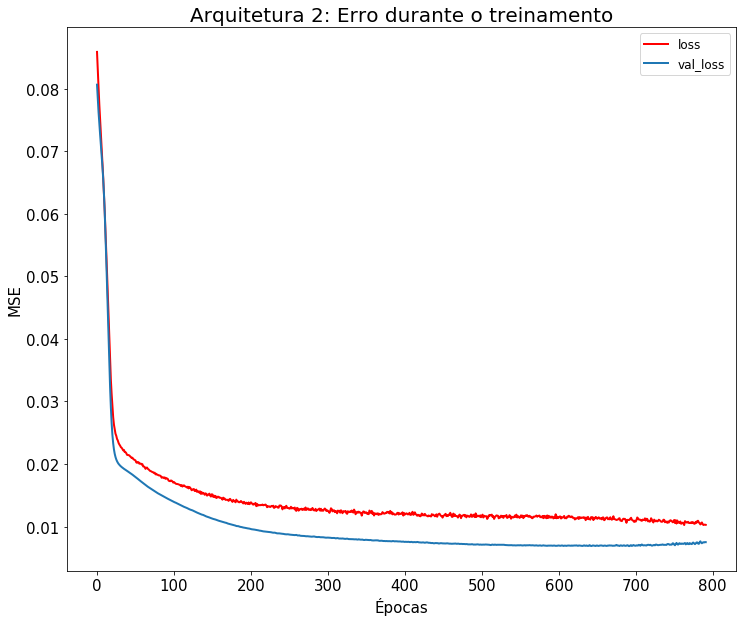

In [272]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history_ae2.history['loss'],color='r',label="loss",linewidth=2)
plt.plot(history_ae2.history['val_loss'],label="val_loss",linewidth=2)
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Arquitetura 2: Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [273]:
np.min(history_ae2.history['loss'])

0.010251009269720978

In [274]:
np.min(history_ae2.history['val_loss'])

0.006889674407816034

## Arquitetura 3: Com BatchNormalization e Relu

In [275]:
# Rede com duas camadas decodificadas e Relu e batch
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
batch1 = BatchNormalization()(entrada)
encoded1 = Dense(encoding_dim1,activation="relu")(batch1)
dp2 = Dropout(0.1)(encoded1) 
encoded2 = Dense(encoding_dim1,activation="relu")(dp2)
batch2 = BatchNormalization()(encoded2)
decoded = Dense(input_dim,activation="sigmoid")(batch2)

In [276]:
# Cria o modelo para a rede anteriormente montada
ae3 = Model(entrada,decoded)

In [277]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
ae3.compile(optimizer='adam', loss='mse')

In [278]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history_ae3 = ae3.fit(X_trainAtMes, X_trainAtMes,
                epochs=10000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 1800 samples, validate on 772 samples
Epoch 1/10000
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0996 - val_loss: 0.0922
Epoch 2/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0970 - val_loss: 0.0897
Epoch 3/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0948 - val_loss: 0.0876
Epoch 4/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0919 - val_loss: 0.0854
Epoch 5/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0899 - val_loss: 0.0834
Epoch 6/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0874 - val_loss: 0.0817
Epoch 7/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0845 - val_loss: 0.0800
Epoch 8/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0827 - val_loss: 0.0783
Epoch 9/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0813 - val_loss: 0.0768


1800/1800 [==============================] - 0s 16us/step - loss: 0.0143 - val_loss: 0.0127
Epoch 78/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0142 - val_loss: 0.0126
Epoch 79/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0142 - val_loss: 0.0124
Epoch 80/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0139 - val_loss: 0.0123
Epoch 81/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0139 - val_loss: 0.0122
Epoch 82/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0138 - val_loss: 0.0121
Epoch 83/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0136 - val_loss: 0.0120
Epoch 84/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0138 - val_loss: 0.0119
Epoch 85/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0133 - val_loss: 0.0118
Epoch 86/10000
1800/1800 [==========================

Epoch 153/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0078 - val_loss: 0.0064
Epoch 154/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0079 - val_loss: 0.0064
Epoch 155/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0079 - val_loss: 0.0063
Epoch 156/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0077 - val_loss: 0.0063
Epoch 157/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0076 - val_loss: 0.0062
Epoch 158/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0075 - val_loss: 0.0062
Epoch 159/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0076 - val_loss: 0.0061
Epoch 160/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0076 - val_loss: 0.0061
Epoch 161/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0077 - val_loss: 0.0061
Epoch 162/10000
1800/1800 [=

Epoch 229/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0059 - val_loss: 0.0045
Epoch 230/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0060 - val_loss: 0.0044
Epoch 231/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0060 - val_loss: 0.0044
Epoch 232/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0060 - val_loss: 0.0044
Epoch 233/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0061 - val_loss: 0.0044
Epoch 234/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0060 - val_loss: 0.0044
Epoch 235/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0059 - val_loss: 0.0044
Epoch 236/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0061 - val_loss: 0.0044
Epoch 237/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0059 - val_loss: 0.0044
Epoch 238/10000
1800/1800 [=

1800/1800 [==============================] - 0s 21us/step - loss: 0.0053 - val_loss: 0.0038
Epoch 305/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 306/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 307/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 308/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 309/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 310/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0053 - val_loss: 0.0037
Epoch 311/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0054 - val_loss: 0.0037
Epoch 312/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0056 - val_loss: 0.0037
Epoch 313/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 16us/step - loss: 0.0049 - val_loss: 0.0034
Epoch 381/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0052 - val_loss: 0.0034
Epoch 382/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 383/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 384/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0050 - val_loss: 0.0033
Epoch 385/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0051 - val_loss: 0.0033
Epoch 386/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0050 - val_loss: 0.0033
Epoch 387/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0051 - val_loss: 0.0033
Epoch 388/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0051 - val_loss: 0.0033
Epoch 389/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 21us/step - loss: 0.0048 - val_loss: 0.0031
Epoch 457/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 458/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 459/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 460/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0048 - val_loss: 0.0031
Epoch 461/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0048 - val_loss: 0.0031
Epoch 462/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0049 - val_loss: 0.0031
Epoch 463/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0048 - val_loss: 0.0030
Epoch 464/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0050 - val_loss: 0.0030
Epoch 465/10000
1800/1800 [=================

Epoch 532/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0045 - val_loss: 0.0028
Epoch 533/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0046 - val_loss: 0.0028
Epoch 534/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0046 - val_loss: 0.0028
Epoch 535/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0045 - val_loss: 0.0028
Epoch 536/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0046 - val_loss: 0.0028
Epoch 537/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0045 - val_loss: 0.0028
Epoch 538/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0045 - val_loss: 0.0028
Epoch 539/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0044 - val_loss: 0.0028
Epoch 540/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0044 - val_loss: 0.0028
Epoch 541/10000
1800/1800 [=

Epoch 608/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 609/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 610/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 611/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 612/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 613/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0046 - val_loss: 0.0026
Epoch 614/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0045 - val_loss: 0.0027
Epoch 615/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0045 - val_loss: 0.0027
Epoch 616/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 617/10000
1800/1800 [=

Epoch 684/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0044 - val_loss: 0.0026
Epoch 685/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0041 - val_loss: 0.0026
Epoch 686/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 687/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 688/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0026
Epoch 689/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 690/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0044 - val_loss: 0.0026
Epoch 691/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 692/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0042 - val_loss: 0.0026
Epoch 693/10000
1800/1800 [=

Epoch 760/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 761/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 762/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 763/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 764/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 765/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 766/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 767/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 768/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 769/10000
1800/1800 [=

Epoch 836/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 837/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 838/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0040 - val_loss: 0.0025
Epoch 839/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 840/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 841/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 842/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0044 - val_loss: 0.0025
Epoch 843/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 844/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 845/10000
1800/1800 [=

1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 912/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 913/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0044 - val_loss: 0.0025
Epoch 914/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 915/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0044 - val_loss: 0.0025
Epoch 916/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 917/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 918/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 919/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 920/10000
1800/1800 [=================

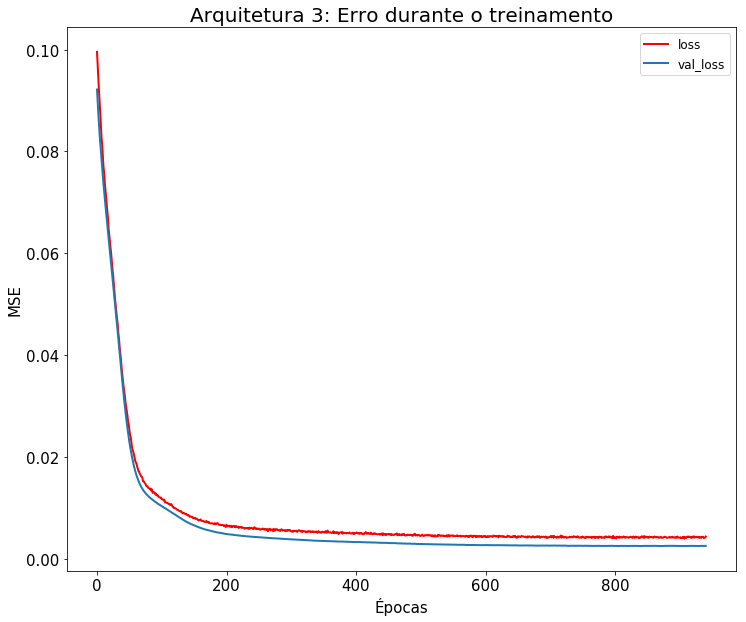

In [279]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history_ae3.history['loss'],color='r',label="loss",linewidth=2)
plt.plot(history_ae3.history['val_loss'],label="val_loss",linewidth=2)
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Arquitetura 3: Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [280]:
np.min(history_ae3.history['loss'])

0.003956568643916398

In [281]:
np.min(history_ae3.history['val_loss'])

0.0024874965935327846

## Arquitetura 4 :Sem BatchNormalization e com Tanh

In [282]:
# Sem batch e com Tanh
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
encoded1 = Dense(encoding_dim1,activation="tanh")(entrada)
dp2 = Dropout(0.1)(encoded1) 
encoded2 = Dense(encoding_dim1,activation="tanh")(dp2)
decoded = Dense(input_dim,activation="sigmoid")(encoded2)

In [283]:
# Cria o modelo para a rede anteriormente montada
ae4 = Model(entrada,decoded)

In [284]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
ae4.compile(optimizer='adam', loss='mse')

In [285]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history_ae4 = ae4.fit(X_trainAtMes, X_trainAtMes,
                epochs=10000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 1800 samples, validate on 772 samples
Epoch 1/10000
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0804 - val_loss: 0.0781
Epoch 2/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0765 - val_loss: 0.0741
Epoch 3/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0727 - val_loss: 0.0708
Epoch 4/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0699 - val_loss: 0.0680
Epoch 5/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0673 - val_loss: 0.0656
Epoch 6/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0651 - val_loss: 0.0633
Epoch 7/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0629 - val_loss: 0.0611
Epoch 8/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0609 - val_loss: 0.0590
Epoch 9/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0589 - val_loss: 0.0568


1800/1800 [==============================] - 0s 17us/step - loss: 0.0181 - val_loss: 0.0170
Epoch 78/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0181 - val_loss: 0.0169
Epoch 79/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0180 - val_loss: 0.0168
Epoch 80/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0178 - val_loss: 0.0167
Epoch 81/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0177 - val_loss: 0.0166
Epoch 82/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0176 - val_loss: 0.0164
Epoch 83/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0174 - val_loss: 0.0163
Epoch 84/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0173 - val_loss: 0.0162
Epoch 85/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0172 - val_loss: 0.0161
Epoch 86/10000
1800/1800 [==========================

1800/1800 [==============================] - 0s 14us/step - loss: 0.0100 - val_loss: 0.0088
Epoch 154/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0099 - val_loss: 0.0087
Epoch 155/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0099 - val_loss: 0.0086
Epoch 156/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0098 - val_loss: 0.0086
Epoch 157/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0097 - val_loss: 0.0085
Epoch 158/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0096 - val_loss: 0.0084
Epoch 159/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0095 - val_loss: 0.0083
Epoch 160/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0094 - val_loss: 0.0082
Epoch 161/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0094 - val_loss: 0.0082
Epoch 162/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 17us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 230/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0074 - val_loss: 0.0064
Epoch 231/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 232/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 233/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0074 - val_loss: 0.0064
Epoch 234/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 235/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0074 - val_loss: 0.0064
Epoch 236/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0073 - val_loss: 0.0063
Epoch 237/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0074 - val_loss: 0.0063
Epoch 238/10000
1800/1800 [=================

Epoch 305/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0066 - val_loss: 0.0056
Epoch 306/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0065 - val_loss: 0.0056
Epoch 307/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0065 - val_loss: 0.0056
Epoch 308/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0066 - val_loss: 0.0056
Epoch 309/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0065 - val_loss: 0.0056
Epoch 310/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0065 - val_loss: 0.0055
Epoch 311/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0064 - val_loss: 0.0055
Epoch 312/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0065 - val_loss: 0.0055
Epoch 313/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0065 - val_loss: 0.0055
Epoch 314/10000
1800/1800 [=

Epoch 381/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0053 - val_loss: 0.0044
Epoch 382/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0053 - val_loss: 0.0044
Epoch 383/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0053 - val_loss: 0.0044
Epoch 384/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0053 - val_loss: 0.0044
Epoch 385/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0053 - val_loss: 0.0044
Epoch 386/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 387/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0053 - val_loss: 0.0043
Epoch 388/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 389/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0053 - val_loss: 0.0043
Epoch 390/10000
1800/1800 [=

Epoch 457/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0041 - val_loss: 0.0032
Epoch 458/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0042 - val_loss: 0.0032
Epoch 459/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 460/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 461/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 462/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 463/10000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 464/10000
1800/1800 [==============================] - 0s 34us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 465/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 466/10000
1800/1800 [=

Epoch 533/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0036 - val_loss: 0.0026
Epoch 534/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0036 - val_loss: 0.0026
Epoch 535/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0036 - val_loss: 0.0026
Epoch 536/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0037 - val_loss: 0.0026
Epoch 537/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0037 - val_loss: 0.0026
Epoch 538/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0036 - val_loss: 0.0026
Epoch 539/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0026
Epoch 540/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0036 - val_loss: 0.0026
Epoch 541/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0037 - val_loss: 0.0026
Epoch 542/10000
1800/1800 [=

Epoch 609/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0034 - val_loss: 0.0024
Epoch 610/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0034 - val_loss: 0.0024
Epoch 611/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0034 - val_loss: 0.0024
Epoch 612/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 613/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0034 - val_loss: 0.0024
Epoch 614/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 615/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 616/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 617/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 618/10000
1800/1800 [=

Epoch 685/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 686/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 687/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 688/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 689/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 690/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 691/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 692/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 693/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 694/10000
1800/1800 [=

1800/1800 [==============================] - 0s 18us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 761/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 762/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 763/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 764/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 765/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 766/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 767/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 768/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 769/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 16us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 837/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 838/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 839/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 840/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 841/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 842/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 843/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 844/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 845/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 14us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 913/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 914/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 915/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 916/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 917/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 918/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 919/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 920/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 921/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 989/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 990/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 991/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 992/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 993/10000
1800/1800 [==============================] - ETA: 0s - loss: 0.002 - 0s 16us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 994/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 995/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 996/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 997/10000
1800

1800/1800 [==============================] - 0s 17us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1064/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1065/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 1066/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1067/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1068/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1069/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0015
Epoch 1070/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1071/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 1072/10000
1800/1800 [========

1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 1139/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 1140/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 1141/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 1142/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 1143/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 1144/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 1145/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 1146/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 1147/10000
1800/1800 [========

1800/1800 [==============================] - 0s 16us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 1214/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1215/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1216/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 1217/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 1218/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1219/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 1220/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1221/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1222/10000
1800/1800 [========

1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1289/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1290/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1291/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1292/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1293/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1294/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1295/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1296/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1297/10000
1800/1800 [========

1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 1364/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1365/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1366/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1367/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1368/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1369/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 1370/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1371/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1372/10000
1800/1800 [========

1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1439/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1440/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 1441/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1442/10000
1800/1800 [==============================] - ETA: 0s - loss: 0.002 - 0s 19us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1443/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1444/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1445/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1446/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1447/1

1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1514/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1515/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1516/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1517/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1518/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1519/10000
1800/1800 [==============================] - 0s 29us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1520/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1521/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1522/10000
1800/1800 [========

1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1589/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1590/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1591/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1592/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1593/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1594/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1595/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1596/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1597/10000
1800/1800 [========

1800/1800 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1664/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1665/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1666/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1667/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1668/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1669/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1670/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1671/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1672/10000
1800/1800 [========

1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1739/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1740/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1741/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1742/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1743/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1744/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1745/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1746/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1747/10000
1800/1800 [========

1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1814/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1815/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1816/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1817/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1818/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1819/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1820/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 1821/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1822/10000
1800/1800 [========

1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1889/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1890/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1891/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1892/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 1893/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1894/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1895/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1896/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1897/10000
1800/1800 [========

1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1964/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1965/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1966/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 1967/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1968/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1969/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1970/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1971/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 1972/10000
1800/1800 [========

1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.9285e-04
Epoch 2038/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 9.9201e-04
Epoch 2039/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.9453e-04
Epoch 2040/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 9.9300e-04
Epoch 2041/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 9.9573e-04
Epoch 2042/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 9.9167e-04
Epoch 2043/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 9.9986e-04
Epoch 2044/10000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 2045/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 20

Epoch 2110/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 9.9315e-04
Epoch 2111/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 9.8739e-04
Epoch 2112/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 9.7904e-04
Epoch 2113/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 9.8595e-04
Epoch 2114/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 9.9463e-04
Epoch 2115/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.9394e-04
Epoch 2116/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0021 - val_loss: 9.8698e-04
Epoch 2117/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 9.8595e-04
Epoch 2118/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_

1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 9.7813e-04
Epoch 2183/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.7811e-04
Epoch 2184/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 9.8458e-04
Epoch 2185/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0023 - val_loss: 9.7562e-04
Epoch 2186/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 9.8063e-04
Epoch 2187/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 9.7501e-04
Epoch 2188/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0021 - val_loss: 9.7735e-04
Epoch 2189/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.8494e-04
Epoch 2190/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 9.7672e-04


1800/1800 [==============================] - 0s 16us/step - loss: 0.0021 - val_loss: 9.7222e-04
Epoch 2255/10000
1800/1800 [==============================] - ETA: 0s - loss: 0.002 - 0s 16us/step - loss: 0.0022 - val_loss: 9.7272e-04
Epoch 2256/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 9.6871e-04
Epoch 2257/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 9.7290e-04
Epoch 2258/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 9.7618e-04
Epoch 2259/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 9.7713e-04
Epoch 2260/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 9.7185e-04
Epoch 2261/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0025 - val_loss: 9.6941e-04
Epoch 2262/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022

1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.6997e-04
Epoch 2327/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 9.6350e-04
Epoch 2328/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0021 - val_loss: 9.7372e-04
Epoch 2329/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 9.7123e-04
Epoch 2330/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 9.6575e-04
Epoch 2331/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 9.6404e-04
Epoch 2332/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 9.6821e-04
Epoch 2333/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 9.6386e-04
Epoch 2334/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 9.6622e-04


1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.6266e-04
Epoch 2399/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0021 - val_loss: 9.6307e-04
Epoch 2400/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 9.5724e-04
Epoch 2401/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 9.6162e-04
Epoch 2402/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.5926e-04
Epoch 2403/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 9.5470e-04
Epoch 2404/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.6019e-04
Epoch 2405/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.5653e-04
Epoch 2406/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.5639e-04


1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 9.5922e-04
Epoch 2471/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.6047e-04
Epoch 2472/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.5650e-04
Epoch 2473/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 9.5703e-04
Epoch 2474/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0021 - val_loss: 9.5715e-04
Epoch 2475/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.4880e-04
Epoch 2476/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.5732e-04
Epoch 2477/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 9.5952e-04
Epoch 2478/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.5859e-04


1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 9.4942e-04
Epoch 2543/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 9.4391e-04
Epoch 2544/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.5117e-04
Epoch 2545/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.4803e-04
Epoch 2546/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 9.5555e-04
Epoch 2547/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 9.4624e-04
Epoch 2548/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 9.5221e-04
Epoch 2549/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0021 - val_loss: 9.4716e-04
Epoch 2550/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.5328e-04


1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 9.4299e-04
Epoch 2615/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.5093e-04
Epoch 2616/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.4942e-04
Epoch 2617/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.4624e-04
Epoch 2618/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.4074e-04
Epoch 2619/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.4326e-04
Epoch 2620/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.4616e-04
Epoch 2621/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 9.4576e-04
Epoch 2622/10000
1800/1800 [==============================] - ETA: 0s - loss: 0.002 - 0s 10us/step - loss: 0.0023

1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 9.4031e-04
Epoch 2687/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0022 - val_loss: 9.4506e-04
Epoch 2688/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0021 - val_loss: 9.3367e-04
Epoch 2689/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 9.4280e-04
Epoch 2690/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0022 - val_loss: 9.4025e-04
Epoch 2691/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 9.3905e-04
Epoch 2692/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0021 - val_loss: 9.3410e-04
Epoch 2693/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 9.3907e-04
Epoch 2694/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.3274e-04


1800/1800 [==============================] - 0s 38us/step - loss: 0.0022 - val_loss: 9.2792e-04
Epoch 2759/10000
1800/1800 [==============================] - 0s 39us/step - loss: 0.0021 - val_loss: 9.2590e-04
Epoch 2760/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 9.2987e-04
Epoch 2761/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0022 - val_loss: 9.2790e-04
Epoch 2762/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 9.2754e-04
Epoch 2763/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 9.3141e-04
Epoch 2764/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0022 - val_loss: 9.3350e-04
Epoch 2765/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0021 - val_loss: 9.3034e-04
Epoch 2766/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0021 - val_loss: 9.2820e-04


1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.2457e-04
Epoch 2831/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0022 - val_loss: 9.2017e-04
Epoch 2832/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 9.2579e-04
Epoch 2833/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 9.1789e-04
Epoch 2834/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0021 - val_loss: 9.1935e-04
Epoch 2835/10000
1800/1800 [==============================] - ETA: 0s - loss: 0.002 - 0s 21us/step - loss: 0.0023 - val_loss: 9.1486e-04
Epoch 2836/10000
1800/1800 [==============================] - 0s 34us/step - loss: 0.0021 - val_loss: 9.2094e-04
Epoch 2837/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 9.2016e-04
Epoch 2838/10000
1800/1800 [==============================] - 0s 30us/step - loss: 0.0022

1800/1800 [==============================] - 0s 11us/step - loss: 0.0021 - val_loss: 9.1536e-04
Epoch 2903/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.1730e-04
Epoch 2904/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.1408e-04
Epoch 2905/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.1562e-04
Epoch 2906/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0020 - val_loss: 9.1681e-04
Epoch 2907/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.1370e-04
Epoch 2908/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0019 - val_loss: 9.2300e-04
Epoch 2909/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.1795e-04
Epoch 2910/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0021 - val_loss: 9.2699e-04


1800/1800 [==============================] - 0s 11us/step - loss: 0.0023 - val_loss: 9.1243e-04
Epoch 2975/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.1625e-04
Epoch 2976/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.1075e-04
Epoch 2977/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 9.2749e-04
Epoch 2978/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.1806e-04
Epoch 2979/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.1746e-04
Epoch 2980/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.0961e-04
Epoch 2981/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 9.0462e-04
Epoch 2982/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.1486e-04


1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.0991e-04
Epoch 3047/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0020 - val_loss: 9.0601e-04
Epoch 3048/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.1379e-04
Epoch 3049/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 9.1356e-04
Epoch 3050/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.1365e-04
Epoch 3051/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0022 - val_loss: 9.0533e-04
Epoch 3052/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0021 - val_loss: 9.0487e-04
Epoch 3053/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.0704e-04
Epoch 3054/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.1475e-04


1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 8.9765e-04
Epoch 3119/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0021 - val_loss: 9.0704e-04
Epoch 3120/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 9.0728e-04
Epoch 3121/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 9.0011e-04
Epoch 3122/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 9.0739e-04
Epoch 3123/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 9.0337e-04
Epoch 3124/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.1332e-04
Epoch 3125/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.0663e-04
Epoch 3126/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0021 - val_loss: 8.9996e-04


1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.0098e-04
Epoch 3191/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 9.0115e-04
Epoch 3192/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 8.9563e-04
Epoch 3193/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 8.9880e-04
Epoch 3194/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.1025e-04
Epoch 3195/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.0153e-04
Epoch 3196/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 9.0960e-04
Epoch 3197/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 8.9916e-04
Epoch 3198/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.0636e-04


1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.0125e-04
Epoch 3263/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0020 - val_loss: 9.0832e-04
Epoch 3264/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.0011e-04
Epoch 3265/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0020 - val_loss: 9.1723e-04
Epoch 3266/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 8.9896e-04
Epoch 3267/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 8.9277e-04
Epoch 3268/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.0733e-04
Epoch 3269/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9861e-04
Epoch 3270/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 9.0096e-04


1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.8910e-04
Epoch 3335/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9165e-04
Epoch 3336/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.9061e-04
Epoch 3337/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0020 - val_loss: 9.0151e-04
Epoch 3338/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0020 - val_loss: 9.0155e-04
Epoch 3339/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0021 - val_loss: 8.9263e-04
Epoch 3340/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0021 - val_loss: 8.9714e-04
Epoch 3341/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9730e-04
Epoch 3342/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9728e-04


1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9660e-04
Epoch 3407/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9776e-04
Epoch 3408/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0021 - val_loss: 8.8872e-04
Epoch 3409/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0020 - val_loss: 8.9244e-04
Epoch 3410/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9352e-04
Epoch 3411/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0021 - val_loss: 8.9879e-04
Epoch 3412/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0021 - val_loss: 8.9844e-04
Epoch 3413/10000
1800/1800 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 8.8674e-04
Epoch 3414/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 8.9197e-04


1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.9791e-04
Epoch 3479/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 8.9504e-04
Epoch 3480/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.9345e-04
Epoch 3481/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.8924e-04
Epoch 3482/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0021 - val_loss: 8.9605e-04
Epoch 3483/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 8.8851e-04
Epoch 3484/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.9059e-04
Epoch 3485/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 8.9595e-04
Epoch 3486/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 8.9323e-04


1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.9612e-04
Epoch 3551/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 8.8544e-04
Epoch 3552/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 8.8982e-04
Epoch 3553/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 8.9347e-04
Epoch 3554/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 8.9248e-04
Epoch 3555/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0020 - val_loss: 8.9590e-04
Epoch 3556/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0020 - val_loss: 8.8916e-04
Epoch 3557/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 8.8976e-04
Epoch 3558/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 8.8554e-04


1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 8.8585e-04
Epoch 3623/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0021 - val_loss: 8.9816e-04
Epoch 3624/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.9437e-04
Epoch 3625/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.9616e-04
Epoch 3626/10000
1800/1800 [==============================] - ETA: 0s - loss: 0.001 - 0s 19us/step - loss: 0.0020 - val_loss: 8.9029e-04
Epoch 3627/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.9531e-04
Epoch 3628/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 8.9662e-04
Epoch 3629/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 8.8419e-04
Epoch 3630/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0020

1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 8.9496e-04
Epoch 3695/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0021 - val_loss: 8.8528e-04
Epoch 3696/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0021 - val_loss: 8.9422e-04
Epoch 3697/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 8.9392e-04
Epoch 3698/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 8.8983e-04
Epoch 3699/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.8774e-04
Epoch 3700/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0020 - val_loss: 8.8890e-04
Epoch 3701/10000
1800/1800 [==============================] - 0s 11us/step - loss: 0.0021 - val_loss: 8.9346e-04
Epoch 3702/10000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 8.9097e-04


1800/1800 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 8.7984e-04
Epoch 3767/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.9408e-04
Epoch 3768/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 8.8970e-04
Epoch 3769/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.8673e-04
Epoch 3770/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 8.9302e-04
Epoch 3771/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0021 - val_loss: 8.7826e-04
Epoch 3772/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 8.9163e-04
Epoch 3773/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0021 - val_loss: 8.9082e-04
Epoch 3774/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 8.8147e-04


1800/1800 [==============================] - 0s 16us/step - loss: 0.0020 - val_loss: 8.8195e-04
Epoch 3839/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 8.8522e-04
Epoch 3840/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 8.8844e-04
Epoch 3841/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0021 - val_loss: 8.8394e-04
Epoch 3842/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 8.8033e-04
Epoch 3843/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 8.8553e-04
Epoch 3844/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0021 - val_loss: 8.8390e-04
Epoch 3845/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 8.8541e-04
Epoch 3846/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0021 - val_loss: 8.8779e-04


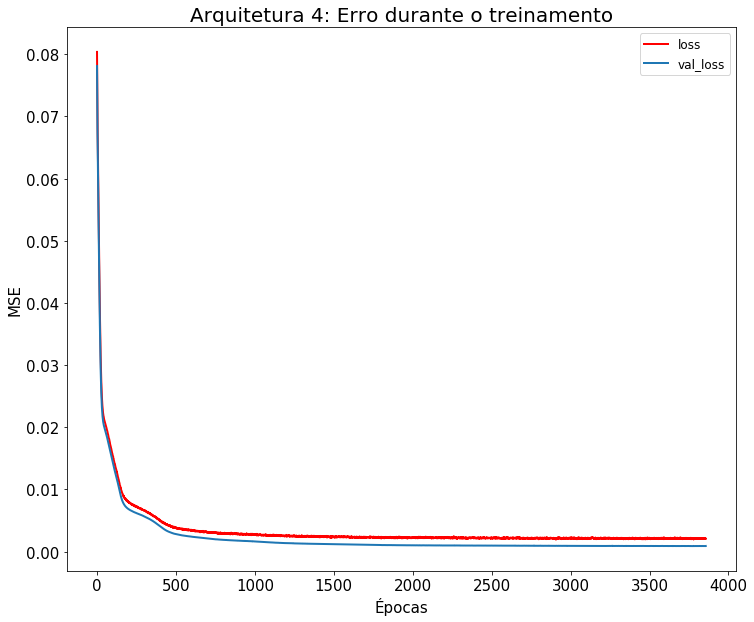

In [286]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history_ae4.history['loss'],color='r',label="loss",linewidth=2)
plt.plot(history_ae4.history['val_loss'],label="val_loss",linewidth=2)
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Arquitetura 4: Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [287]:
np.min(history_ae4.history['loss'])

0.001919648638771226

In [288]:
np.min(history_ae4.history['val_loss'])

0.000876591946290917

## Arquitetura 5: BatchNormalization e Tanh

In [289]:
# Rede com duas camadas decodificadas e batch_normalizzation e Tanh
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
batch1 = BatchNormalization()(entrada)
encoded1 = Dense(encoding_dim1,activation="tanh")(batch1)
dp2 = Dropout(0.1)(encoded1) 
encoded2 = Dense(encoding_dim1,activation="tanh")(dp2)
batch2 = BatchNormalization()(encoded2)
decoded = Dense(input_dim,activation="sigmoid")(batch2)

In [290]:
# Cria o modelo para a rede anteriormente montada
ae5 = Model(entrada,decoded)

In [291]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
ae5.compile(optimizer='adam', loss='mse')

In [292]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history_ae5 = ae5.fit(X_trainAtMes, X_trainAtMes,
                epochs=10000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 1800 samples, validate on 772 samples
Epoch 1/10000
1800/1800 [==============================] - 2s 1ms/step - loss: 0.1087 - val_loss: 0.1044
Epoch 2/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.1045 - val_loss: 0.1005
Epoch 3/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.1007 - val_loss: 0.0970
Epoch 4/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0970 - val_loss: 0.0937
Epoch 5/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0936 - val_loss: 0.0906
Epoch 6/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0905 - val_loss: 0.0877
Epoch 7/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0876 - val_loss: 0.0849
Epoch 8/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0847 - val_loss: 0.0822
Epoch 9/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0820 - val_loss: 0.0795


1800/1800 [==============================] - 0s 16us/step - loss: 0.0105 - val_loss: 0.0093
Epoch 78/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0102 - val_loss: 0.0090
Epoch 79/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0100 - val_loss: 0.0088
Epoch 80/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0096 - val_loss: 0.0086
Epoch 81/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0094 - val_loss: 0.0083
Epoch 82/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0092 - val_loss: 0.0081
Epoch 83/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0089 - val_loss: 0.0079
Epoch 84/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0088 - val_loss: 0.0077
Epoch 85/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0087 - val_loss: 0.0075
Epoch 86/10000
1800/1800 [==========================

1800/1800 [==============================] - 0s 15us/step - loss: 0.0042 - val_loss: 0.0032
Epoch 154/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 155/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 156/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 157/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 158/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 159/10000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 160/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0040 - val_loss: 0.0030
Epoch 161/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0030
Epoch 162/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 19us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 230/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 231/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 232/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 233/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 234/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 235/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 236/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 237/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0034 - val_loss: 0.0022
Epoch 238/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 306/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 307/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 308/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 309/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 310/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 311/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 312/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 313/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 314/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 14us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 382/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 383/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 384/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 385/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 386/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 387/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 388/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 389/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 390/10000
1800/1800 [=================

Epoch 457/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 458/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 459/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 460/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 461/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 462/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 463/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 464/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 465/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 466/10000
1800/1800 [=

1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 533/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 534/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 535/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 536/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 537/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 538/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 539/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 540/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 541/10000
1800/1800 [=================

1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 609/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 610/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 611/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 612/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 613/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 614/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 615/10000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 616/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 617/10000
1800/1800 [=================

Epoch 684/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 685/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 686/10000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 687/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 688/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 689/10000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 690/10000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 691/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0025 - val_loss: 0.0010
Epoch 692/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 693/10000
1800/1800 [=

Epoch 760/10000
1800/1800 [==============================] - 0s 33us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 761/10000
1800/1800 [==============================] - 0s 31us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 762/10000
1800/1800 [==============================] - 0s 34us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 763/10000
1800/1800 [==============================] - 0s 29us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 764/10000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 765/10000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 766/10000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 767/10000
1800/1800 [==============================] - 0s 32us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 768/10000
1800/1800 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 769/10000
1800/1800 [=

1800/1800 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 836/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 837/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 838/10000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 839/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 840/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 841/10000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 842/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 843/10000
1800/1800 [==============================] - 0s 38us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 844/10000
1800/1800 [=================

Epoch 910/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0023 - val_loss: 9.8662e-04
Epoch 911/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 9.9916e-04
Epoch 912/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 913/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 914/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0023 - val_loss: 9.9775e-04
Epoch 915/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0023 - val_loss: 9.9666e-04
Epoch 916/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 917/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 918/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 919/10

1800/1800 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 985/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 986/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 9.7696e-04
Epoch 987/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.6954e-04
Epoch 988/10000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0023 - val_loss: 9.5925e-04
Epoch 989/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0022 - val_loss: 9.5501e-04
Epoch 990/10000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 9.5330e-04
Epoch 991/10000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 9.6188e-04
Epoch 992/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 9.6282e-04
Epoch 993/10000


1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 9.8573e-04
Epoch 1057/10000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0024 - val_loss: 9.8812e-04
Epoch 1058/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 9.8168e-04
Epoch 1059/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 9.7505e-04
Epoch 1060/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0023 - val_loss: 9.7811e-04
Epoch 1061/10000
1800/1800 [==============================] - 0s 44us/step - loss: 0.0022 - val_loss: 9.7007e-04
Epoch 1062/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 9.6798e-04
Epoch 1063/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 9.6712e-04
Epoch 1064/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 9.8034e-04


1800/1800 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 9.5884e-04
Epoch 1129/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 9.6191e-04
Epoch 1130/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 9.6854e-04
Epoch 1131/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 9.7422e-04
Epoch 1132/10000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 9.6561e-04
Epoch 1133/10000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0021 - val_loss: 9.7546e-04
Epoch 1134/10000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0023 - val_loss: 9.8554e-04
Epoch 1135/10000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 9.9521e-04
Epoch 1136/10000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0010
Epoc

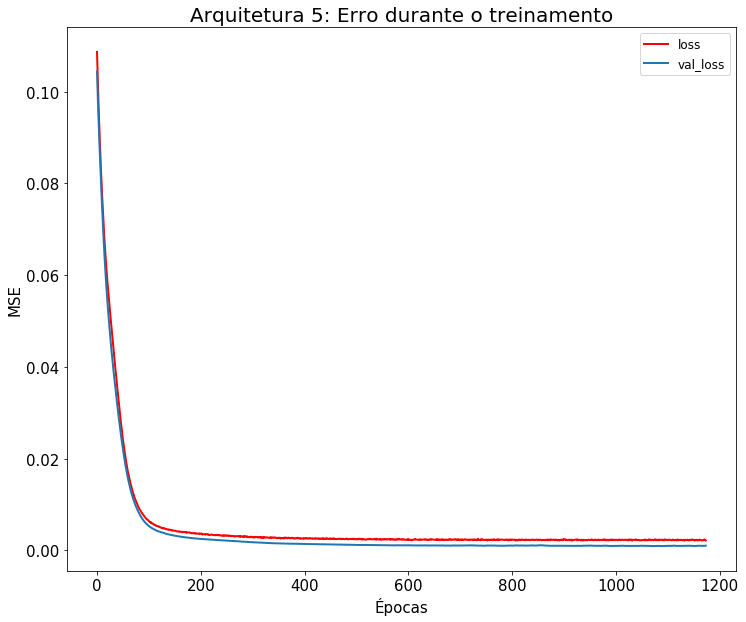

In [293]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history_ae5.history['loss'],color='r',label="loss",linewidth=2)
plt.plot(history_ae5.history['val_loss'],label="val_loss",linewidth=2)
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Arquitetura 5: Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [294]:
np.min(history_ae5.history['loss'])

0.0021194932768897464

In [295]:
np.min(history_ae5.history['val_loss'])

0.0009257723344339135

# Teste de Modelo e Estimação de Probabilidade

In [296]:
def distancia(entrada):
    recons = final_autoencoder.predict(entrada)
    return norm(entrada-recons)

In [297]:
# Pn = e^-(||x-x^||)
def estimar_prob1(entrada):
    recons = final_autoencoder.predict(entrada)
    return pow(math.e, -norm(entrada-recons))

In [298]:
# Estima a probabilidade para o testset
ests = []
for i in X_testAtMes.index:
    ests.append(estimar_prob1(np.array(X_testAtMes.loc[i]).reshape(1,21)))

In [308]:
# Cria um dicionário com a estimativa e a distância para o gráfico
estsd = {}
for i in X_testAtMes.index:
    estsd[estimar_prob1(np.array(X_testAtMes.loc[i]).reshape(1,21))*100] = distancia(np.array(X_testAtMes.loc[i]).reshape(1,21))
est, dist = classifica_dict(estsd, False)

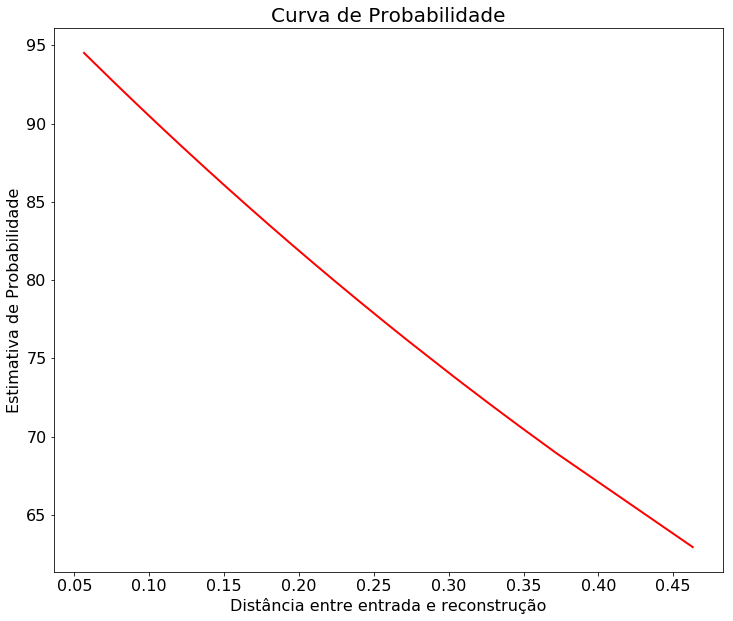

In [311]:
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=16)
plt.plot(dist,est,color='r',linewidth=2)
plt.xlabel(u'Distância entre entrada e reconstrução')
plt.ylabel('Estimativa de Probabilidade')
plt.title('Curva de Probabilidade')
plt.show()

# Heatmap do Canadá

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
def sampling(lon_min=-142, lon_max=-53, lat_min=41, lat_max=75, n_points=500):    
    lat = np.array([])
    lon = np.array([])
    pts = 0
    
    bm = Basemap(projection='cyl', resolution='l',
            llcrnrlat=lat_min, urcrnrlat=lat_max,
            llcrnrlon=lon_min, urcrnrlon=lon_max)

    while pts < n_points:
        x = np.random.uniform(lat_min,lat_max,1)
        y = np.random.uniform(lon_max,lon_min,1)
        
        if bm.is_land(y, x):
            lat = np.hstack((lat, x)) 
            lon = np.hstack((lon, y)) 
            pts = pts + 1
        
    return (lat , lon)

In [ ]:
lon_min=-141.5
lon_max=-54
lat_min=42
lat_max=72
lat , lon = sampling(lon_min, lon_max, lat_min, lat_max)

In [ ]:
fig = plt.figure(figsize=(20, 30))
bm = Basemap(projection='cyl', resolution='l',
            llcrnrlat=lat_min, urcrnrlat=lat_max,
            llcrnrlon=lon_min, urcrnrlon=lon_max)
bm.shadedrelief()
bm.drawcoastlines(color='black')
bm.drawcountries(color='green',linewidth=3)
bm.drawstates(color='gray')
Z = np.ones((lon,lat),dtype=np.float64)
#https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.contourf
#levels = np.linspace(0, 1, 10)
#bm.collorbar()
#bm.contourf(lon, lat, Z, levels)
bm.scatter(lon, lat, latlon=True, s=40, c='red', alpha=0.5)
plt.show()

In [ ]:
levels = np.linspace(Z.min(), Z.max(), 25)
Z[land_reference == -9999] = -9999

# plot contours of the prediction
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.colorbar(format='%.2f')